### Importar bibliotecas e carregar dados

Importa todas as dependências necessárias, lê o arquivo `aula_01_exemplo_01.csv`, cria a coluna derivada `tem_filhos` e exibe uma amostra inicial do conjunto de dados.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef, ConfusionMatrixDisplay, RocCurveDisplay

import numpy as np

import matplotlib.pyplot as plt

df = pd.read_csv('aula_01_exemplo_01.csv')

df['tem_filhos'] = (df['children'] > 0).astype(int)

df.head()


,age,sex,bmi,children,smoker,region,charges,tem_filhos
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


### Categorizar a variável target pela mediana

Metada das observações estarão em um grupo e metada em outro

In [4]:
mediana_charges = df['charges'].median()

print('Valor da Mediana:', mediana_charges)

df['custos_categoricos'] = (df['charges'] >= mediana_charges).astype(int)

df[['charges', 'custos_categoricos']].head()

Valor da Mediana: 9382.033


,charges,custos_categoricos
0,16884.92400,1
1,1725.55230,0
2,4449.46200,0
3,21984.47061,1
4,3866.85520,0


## Analisar as categorias

In [5]:
df['custos_categoricos'].value_counts()

custos_categoricos
1    669
0    669
Name: count, dtype: int64

## Definir a variável target e preditoras

In [6]:
X = df.drop(['custos_categoricos', 'charges'], axis=1)

Y = df['custos_categoricos']

X.head()

,age,sex,bmi,children,smoker,region,tem_filhos
0,19,female,27.900,0,yes,southwest,0
1,18,male,33.770,1,no,southeast,1
2,28,male,33.000,3,no,southeast,1
3,33,male,22.705,0,no,northwest,0
4,32,male,28.880,0,no,northwest,0


## Definir as variáveis categóricas e numéricas

In [7]:
variaveis_categoricas = ['sex', 'smoker', 'region']
variaveis_numericas = ['age', 'bmi', 'children', 'tem_filhos']

## Dividir entre conjuntos de treino e teste

Realiza a partição estratificada do conjunto de dados em bases de treino e teste usando `train_test_split` e informa a quantidade de linhas e colunas resultante de cada partição.

In [8]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

print('Número de linhas e colunas da base de treino: ', x_treino.shape)
print('Número de linhas e colunas da base de teste: ', x_teste.shape)

Número de linhas e colunas da base de treino:  (1070, 7)
Número de linhas e colunas da base de teste:  (268, 7)


## Ajustar base

Instancia os objetos de imputação e transformação, incluindo `StandardScaler`, `SimpleImputer` para dados numéricos e categóricos, além do `OneHotEncoder` para codificar variáveis qualitativas.

In [9]:
escalonador = StandardScaler()

imputador_numerico = SimpleImputer(strategy='median')

categorizador = OneHotEncoder(drop='first', handle_unknown='ignore')

imputador_categorico = SimpleImputer(strategy='most_frequent')

## Criar pipeline para atributos numéricos

Monta um pipeline que primeiro trata valores ausentes nas colunas numéricas com a mediana e, em seguida, aplica a padronização dos dados.

In [10]:
etapas_numericas = Pipeline (
    [
        ("imputer", imputador_numerico),
        ('scaler', escalonador)
    ]
)

etapas_numericas

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


## Criar pipeline para atributos categóricos

Constrói o pipeline responsável por imputar categorias faltantes com o valor mais frequente e aplicar codificação one-hot nas variáveis categóricas.

In [11]:
etapas_categoricas = Pipeline(
    [
        ('imputer', imputador_categorico),
        ('enconder', categorizador)
    ]
)

etapas_categoricas

,steps,"[('imputer', ...), ('enconder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


## Integrar pipelines numérico e categórico e transformar dados

Integra os pipelines numérico e categórico em um `ColumnTransformer`, ajusta-o nos dados de treino e gera matrizes transformadas para treino e teste, permitindo verificar o formato final após as etapas de pré-processamento.

In [12]:
preprocessador = ColumnTransformer(
    [
        ('num', etapas_numericas, variaveis_numericas),
        ('cat', etapas_categoricas, variaveis_categoricas)
    ]
)

x_treino_transformado = preprocessador.fit_transform(x_treino)
x_teste_transformado = preprocessador.transform(x_teste)

print(f'Formato do treino transformado: {x_treino_transformado.shape}')
print(f'Formato do teste transformado: {x_teste_transformado.shape}')

if hasattr(x_treino_transformado, 'toarray'):
    primeira_linha = x_treino_transformado[0].toarray().ravel()
else:
    primeira_linha = x_treino_transformado[0]

print('Primeira linha transformada:', primeira_linha)


Formato do treino transformado: (1070, 9)
Formato do teste transformado: (268, 9)
Primeira linha transformada: [ 1.54919786  0.52103271 -0.91158338 -1.16482968  1.          0.
  0.          0.          0.        ]


## Aplicar modelo de classificação `DecisionTreeClassifier`

### Instanciar modelo de classificação

Cria o estimador `DecisionTreeClassifier` que será ajustado aos dados pré-processados.

In [13]:
modelo = DecisionTreeClassifier(random_state=42)

### Definir hiperparâmetros e encontrar melhor modelo

Especifica os valores candidatos de profundidade máxima e tamanho mínimo de divisão que serão avaliados durante a busca por hiperparâmetros.

In [ ]:
param_grid = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 5, 10, 15, 20, 25]
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    scoring="f1"
)

grid_search.fit(x_treino_transformado, y_treino)

melhor_modelo_arvore = grid_search.best_estimator_

### Analisar métricas do modelo

Aplica o melhor modelo de árvore obtido na busca em grade aos dados de treino transformados para calcular métricas de desempenho e inspecionar possíveis sinais de overfitting.

In [16]:
y_pred_treino_arvore = melhor_modelo_arvore.predict(x_treino_transformado)

print('Melhores parâmetros encontrados (árvore): ', grid_search.best_params_)

acuracia_tree = accuracy_score(y_treino, y_pred_treino_arvore)
mcc_tree = matthews_corrcoef(y_treino, y_pred_treino_arvore)

print('=== Métricas de Treino ===')
print('Acuária: ', acuracia_tree)
print('MCC: ', )
print('\nRelatório de classificação:\n', classification_report(y_treino, y_pred_treino_arvore))


Melhores parâmetros encontrados (árvore):  {'max_depth': 7, 'min_samples_split': 25}
=== Métricas de Treino ===
Acuária:  0.9299065420560748
MCC: 

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       535
           1       0.99      0.87      0.93       535

    accuracy                           0.93      1070
   macro avg       0.94      0.93      0.93      1070
weighted avg       0.94      0.93      0.93      1070



### Analisar o desempenho do modelo: matriz de confusão

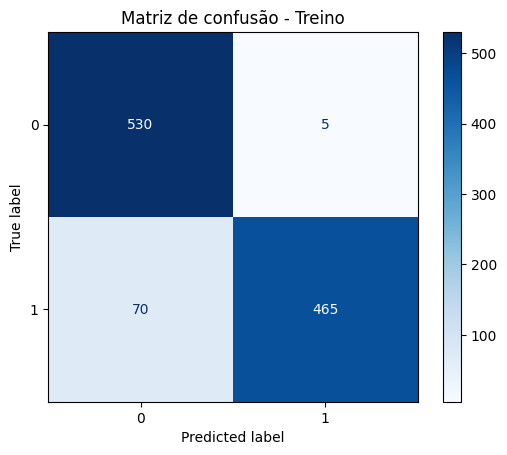

In [17]:
ConfusionMatrixDisplay.from_estimator(
    melhor_modelo_arvore,
    x_treino_transformado,
    y_treino,
    display_labels=[0, 1],
    cmap=plt.cm.Blues,
    normalize=None
)

plt.title("Matriz de confusão - Treino")
plt.show()

### Analisar desempenho do modelo: curva ROC

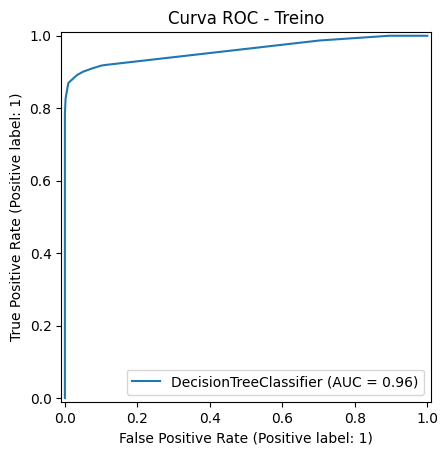

In [18]:
RocCurveDisplay.from_estimator(
    melhor_modelo_arvore,
    x_treino_transformado,
    y_treino
)

plt.title('Curva ROC - Treino')
plt.show()

## Aplicar modelo de classificação `KNeighborsClassifier`

### Instanciar modelo de classificação 

In [19]:
modelo_knn = KNeighborsClassifier()

### Definir hiperparâmetros e encontrar melhor modelo

In [ ]:
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "p": [1, 2]
}

grid_search_knn = GridSearchCV(
    estimator=modelo_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring="f1"
)

grid_search_knn.fit(x_treino_transformado, y_treino)

melhor_modelo_knn = grid_search_knn.best_estimator_

### Analisar métricas do modelo

In [22]:
y_pred_treino_knn = melhor_modelo_knn.predict(x_treino_transformado)

acuracia_knn = accuracy_score(y_treino, y_pred_treino_knn)
mcc_knn = matthews_corrcoef(y_treino, y_pred_treino_knn)

print("=== Métricas de Treino ===")
print("Acurácia: ", acuracia_knn)
print("MCC: ", mcc_knn)
print("\nRelatório de Classificação:\n", classification_report(y_treino, y_pred_treino_knn))

=== Métricas de Treino ===
Acurácia:  0.9018691588785047
MCC:  0.8063470194624572

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91       535
           1       0.94      0.86      0.90       535

    accuracy                           0.90      1070
   macro avg       0.90      0.90      0.90      1070
weighted avg       0.90      0.90      0.90      1070



### Analisar o desempenho do modelo: matriz de confusão

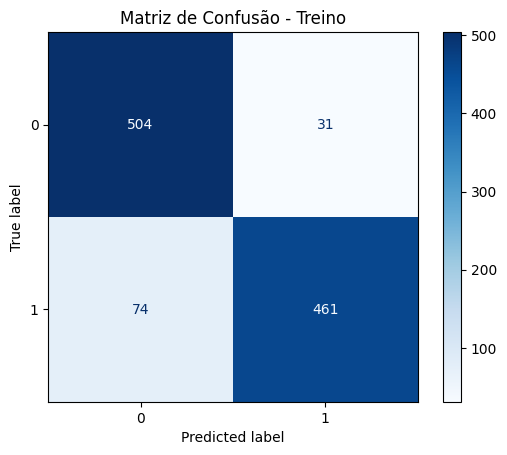

In [23]:
ConfusionMatrixDisplay.from_estimator(
    melhor_modelo_knn,
    x_treino_transformado,
    y_treino,
    display_labels=[0, 1],
    cmap=plt.cm.Blues,
    normalize=None
)

plt.title("Matriz de Confusão - Treino")
plt.show()

### Analisar o desempenho do modelo: curva ROC

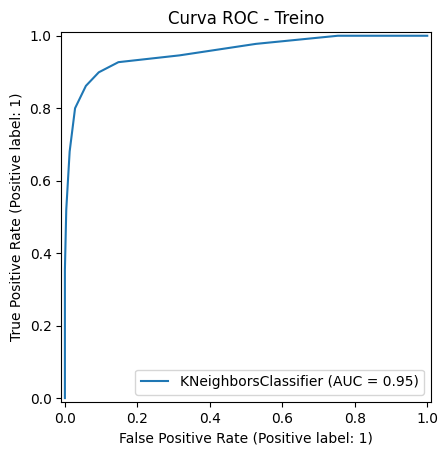

In [24]:
RocCurveDisplay.from_estimator(
    melhor_modelo_knn,
    x_treino_transformado,
    y_treino
)

plt.title("Curva ROC - Treino")
plt.show()

## Aplicar modelo de classificação `Support Vector Classifier`

### Instanciar modelo de classificação 

In [25]:
modelo_svc = SVC(probability=True)

### Definir hiperparâmetros e encontrar melhor modelo

In [ ]:
param_grid_svc = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

grid_search_svc = GridSearchCV(
    estimator=modelo_svc,
    param_grid=param_grid_svc,
    cv=5,
    scoring="f1"
)

grid_search_svc.fit(x_treino_transformado, y_treino)

melhor_modelo_svc = grid_search_svc.best_estimator_

### Analisar métricas do modelo

In [28]:
y_pred_treino_svc = melhor_modelo_svc.predict(x_treino_transformado)

acuracia_svc = accuracy_score(y_treino, y_pred_treino_svc)
mcc_svc = matthews_corrcoef(y_treino, y_pred_treino_svc)

print("=== Métricas de Treino ===")
print("Acurácia: ", acuracia_svc)
print("MCC: ", mcc_svc)
print("\nRelatório de Classificação:\n", classification_report(y_treino, y_pred_treino_svc))

=== Métricas de Treino ===
Acurácia:  0.9411214953271028
MCC:  0.885106495782046

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       535
           1       0.98      0.90      0.94       535

    accuracy                           0.94      1070
   macro avg       0.94      0.94      0.94      1070
weighted avg       0.94      0.94      0.94      1070



### Analisar o desempenho do modelo: matriz de confusão

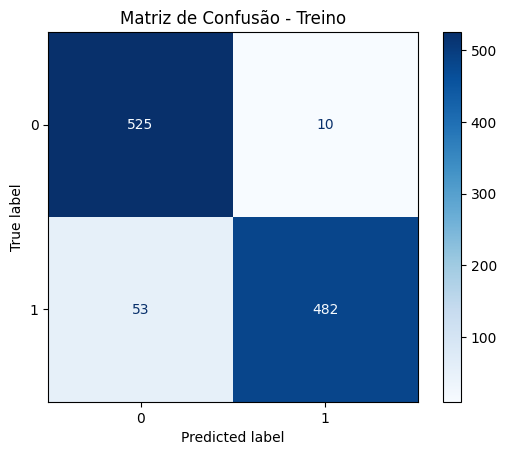

In [29]:
ConfusionMatrixDisplay.from_estimator(
    melhor_modelo_svc,
    x_treino_transformado,
    y_treino,
    display_labels=[0, 1],
    cmap=plt.cm.Blues,
    normalize=None
)

plt.title("Matriz de Confusão - Treino")
plt.show()

### Analisar o desempenho do modelo: curva ROC

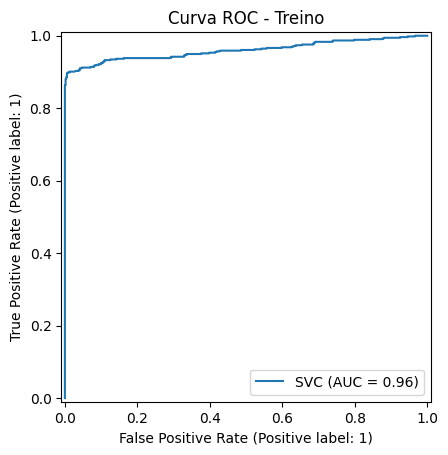

In [30]:
RocCurveDisplay.from_estimator(
    melhor_modelo_svc,
    x_treino_transformado,
    y_treino
)

plt.title("Curva ROC - Treino")
plt.show()

## Aplicar modelo de classificação `LogisticRegression`

### Instanciar modelo de classificação

In [35]:
modelo_lr = LogisticRegression(max_iter=1000)

### Definir hiperparâmetros e encontrar melhor modelo

In [36]:
param_grid_lr = {
    "C": [0.01, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_search_lr = GridSearchCV(
    estimator=modelo_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring="f1"
)

grid_search_lr.fit(x_treino_transformado, y_treino)

melhor_modelo_lr = grid_search_lr.best_estimator_

### Analisar métricas do modelo

In [37]:
y_pred_treino_lr = melhor_modelo_lr.predict(x_treino_transformado)

acuracia_lr = accuracy_score(y_treino, y_pred_treino_lr)
mcc_lr = matthews_corrcoef(y_treino, y_pred_treino_lr)

print("=== Métricas de Treino ===")
print("Acurácia: ", acuracia_lr)
print("MCC: ", mcc_lr)
print("\nRelatório de Classificação:\n", classification_report(y_treino, y_pred_treino_lr))

=== Métricas de Treino ===
Acurácia:  0.9074766355140187
MCC:  0.8149660839416788

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       535
           1       0.91      0.91      0.91       535

    accuracy                           0.91      1070
   macro avg       0.91      0.91      0.91      1070
weighted avg       0.91      0.91      0.91      1070



### Analisar o desempenho do modelo: matriz de confusão

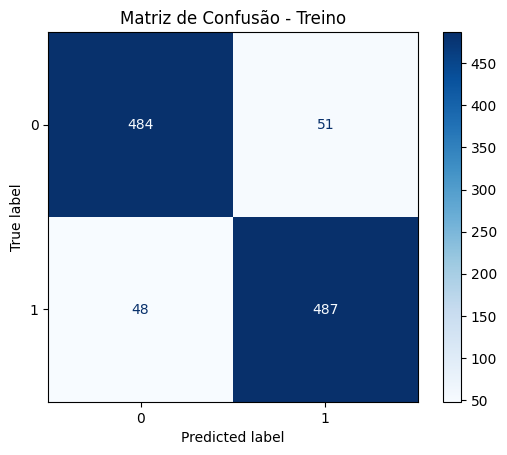

In [38]:
ConfusionMatrixDisplay.from_estimator(
    melhor_modelo_lr,
    x_treino_transformado,
    y_treino,
    display_labels=[0, 1],
    cmap=plt.cm.Blues,
    normalize=None
)

plt.title("Matriz de Confusão - Treino")
plt.show()

### Analisar o desempenho do modelo: curva ROC

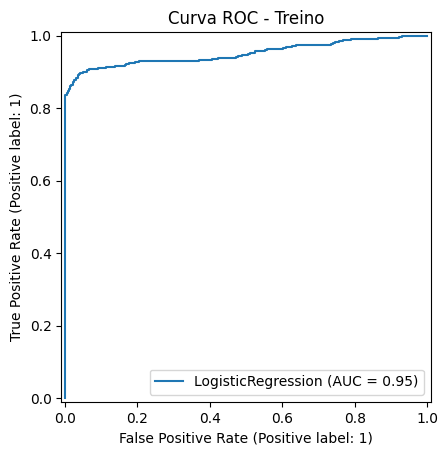

In [40]:
RocCurveDisplay.from_estimator(
    melhor_modelo_lr,
    x_treino_transformado,
    y_treino
)

plt.title("Curva ROC - Treino")
plt.show()

## Conclusões


In [41]:
resumo_metricas = pd.DataFrame(
    [
        ('DecisionTreeClassifier', 'Treino', acuracia_tree, mcc_tree),
        
        ('KNeighborsClassifier', 'Treino', acuracia_knn, mcc_knn),
        
        ('SVC', 'Treino', acuracia_svc, mcc_svc),

        ('LogisticRegression', 'Treino', acuracia_lr, mcc_lr),
    ],
    columns=['Modelo', 'Base', 'Acurária', 'MCC']
)

resumo_metricas.style.format({
    'Acurácia': '{:.3f}',
    'MCC': '{:.3f}'
})

,Modelo,Base,Acurária,MCC
0,DecisionTreeClassifier,Treino,0.929907,0.866
1,KNeighborsClassifier,Treino,0.901869,0.806
2,SVC,Treino,0.941121,0.885
3,LogisticRegression,Treino,0.907477,0.815
